
<img src="ps.png" width="200">

<h1><center>  A new test for Multivariate Normality <br><br>  G.J. Székely and Maria L.Rzzo </center></h1>

<h3>  <p style="text-align:left;">Authors: <span style="float:right;"> Professors:
    <br>  <br> Zoltan Szabo
</span></p>

Damien Grasset <br> Alice Guichenez </h3>


# Outline

## <a href="#1.-Generate-Multivariate-Distribution" style="color:#00925B">1.&nbsp;&nbsp;Generate Multivariate Distribution</a>

## <a href="#2.-Statistics" style="color:#00925B">2.&nbsp;&nbsp;Statistics</a>

-  <a href="#1.-Mardia's-Skewness" style="color:#00925B">2.1.&nbsp;&nbsp;Mardia's Skewness</a>

-  <a href="#2.-Mardia's-Kurtosis" style="color:#00925B">2.2.&nbsp;&nbsp;Mardia's Kurtosis</a>

-  <a href="#3.-BHEP-Statistics-and-Henze-Zirkler" style="color:#00925B">2.3.&nbsp;&nbsp;BHEP Statistics and Henze-Zirkler</a>
-  <a href="#4.-Proposed-Statistic" style="color:#00925B">2.4.&nbsp;&nbsp;Proposed Statistic</a>

## <a href="#3.-Critical-Values" style="color:#00925B">3.&nbsp;&nbsp;Critical Values</a>

## <a href="#4.-Simulations" style="color:#00925B">4.&nbsp;&nbsp;Simulations</a>

-  <a href="#1.-Simulation-n°1" style="color:#00925B">4.1.&nbsp;&nbsp;Simulation n°1</a>
-  <a href="#2.-Simulation-n°2" style="color:#00925B">4.2.&nbsp;&nbsp;Simulation n°2</a>
-  <a href="#3.-Simulation-n°3" style="color:#00925B">4.3.&nbsp;&nbsp;Simulation n°3</a>


So as to assess the performance of the new test associated with the proposed statitsique $\mathcal{E}_{n,d}$, let's do, as proposed in the paper, a comparative Monte Carlo power study of 8 affine invariant tests of multivariate normality. To do so, we will compare our method with differents benchmark statistics and study the positive improvement of the proposed test.

## Packages

In [1]:
import scipy
import pickle
import numpy as np
from math import pi, factorial
from numpy.linalg import norm
from tqdm import tqdm_notebook
from scipy.special import gamma
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.spatial.distance import euclidean as euclidean

import warnings
warnings.filterwarnings("ignore")

# Generate Multivariate Distribution

In [2]:
# Simulations Design 

n = 100 # Sample size
d = 2 # Dimension of the multivariate distribution
p = 0.5 # probability of drawing a center normal distribution
mu_0, mu_1 = [0]*d, [3]*d # mean vectors
I_0  = np.identity(d) # covariance matrices
B = np.ones((d,d))*0.9 + np.identity(d)*0.1 # covariance matrix with 1 on diagonal and 0.9 off diagonal

Let's start by building the sampling function to simulate a normal mixture $pN_d(\mu_1, \Sigma_1) + (1-p)N_d(\mu_2, \Sigma_2)$ which consists in drawing :
- with proba p, a sampled population $pN_d(\mu_1, \Sigma_1)$
- with proba (1-p), a sampled population $pN_d(\mu_2, \Sigma_2)$

In [3]:
def get_samples(p,mu,I,n,d):
    samples = np.zeros((n,d))
    prob = np.random.random(n)
    for i in range(n):
        if prob[i]<p :
            samples[i,:] = np.random.multivariate_normal(mu[0], I[0], 1)[0]
        else :
            samples[i,:] = np.random.multivariate_normal(mu[1], I[1], 1)[0]
    return samples

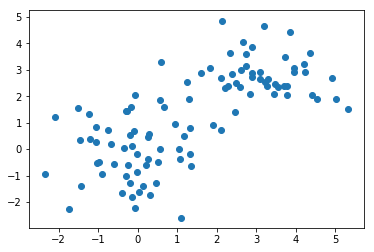

In [4]:
samples = get_samples(0.5, [mu_0, mu_1], [I_0, I_0], 100, 2)
plt.scatter(samples[:,0], samples[:,1])
plt.show()

# Statistics

## 1. Mardia's Skewness

Multivariate Skewness test proposed by Mardia and based on the sample skewness statistic defined as follow : 

$$b_{1,d}=\frac{1}{n^2} \sum\limits_{j,k=1}^n ((X_j - \bar{X})^T \hat{\Sigma}^{-1}(X_k - \bar{X}))^3$$

where $\hat{\Sigma}$ denotes the maximum likelihood estimator of population covariance, $\hat{\Sigma} = \frac{1}{n} \sum\limits_{j}^n (X_j - \bar{X})(X_j - \bar{X})^T$.

One will reject normality of the sample distribution for large values of $b_{1,d}$

In [5]:
def skewness(x,n):
    s = 0
    mean = x.mean(axis=0)
    max_likelihood = (1/n) * np.dot((x - x.mean(axis=0)).T,(x - x.mean(axis=0)))     
    E_inv = np.linalg.inv(max_likelihood)   
    for j in range(n):
        for k in range(n):
            s += np.dot(np.dot((x[j]-mean), E_inv), (x[k]-mean).T)**3
    s = s /n**2
    return s

## 2. Mardia's Kurtosis

Multivariate kurtosis test proposed by Mardia and based on the sample kurtosis statistic defined as follow : 

$$b_{2,d}=\frac{1}{n} \sum\limits_{j=1}^n ((X_j - \bar{X})^T \hat{\Sigma}^{-1}(X_j - \bar{X}))^2$$


In [6]:
def kurtosis(x,n):
    s = 0
    mean = x.mean(axis=0)
    max_likelihood = (1/n) * np.dot((x - x.mean(axis=0)).T,(x - x.mean(axis=0)))
    E_inv = np.linalg.inv(max_likelihood)   
    for j in range(n):
        s += np.dot(np.dot((x[j]-mean), E_inv), (x[j]-mean).T)**2
    s = s / n
    return s

## 3. BHEP Statistics and Henze-Zirkler

**BHEP statistics**

The BHEP (Baringhaus-Henze-Epps-Pulley) statistics $T_{n,d}(\beta)$ are defined  as weighted integral of the squared difference between the multivariate normal characteristic function and the empirical characteristic function $\Psi_n(t) = \frac{1}{n}\sum_{k=1}^n e^{it^TY_k}$, with Y is the standardized sample.

in practise, the BHEP test statistic, for a giben fixed parameter $\beta > 0$ is defined by : 

$$T_{n,d}(\beta) = \frac{1}{n^2}\sum\limits_{j,k=1}^n e^{-(\beta^2/2)||Y_j-Yk||^2} - 2(1+\beta^2)^{-d/2} \frac{1}{n}\sum\limits_{j=1}^n e^{-\beta^2||Y_j||^2/(2(1+\beta^2))} + (1+2\beta^2)^{-d/2}$$

In the following comparaison, we will use several BHEP statistic associated with values of $\beta = .1, .5, 1, 3$

**Henze-Zirkler statistic**

Using the value $\beta = \frac{1}{\sqrt{2}}\left[\frac{(2d+1)n}{4}\right]^{1/(d+4)}$, it corresponds to choosing the optimal bandwith for a multivariate nonparametric kernel density estimator with Gaussian kernel associated with the BHEP statistic. This particular choice of $\beta$ defines the Henze-Zirkler test, that we will denote HZ.

In [7]:
def get_standardized_samples(x):
    n = x.shape[0]
    max_likelihood = np.dot((x - x.mean(axis=0)).T,(x - x.mean(axis=0)))/n
    A_inv = scipy.linalg.inv(max_likelihood) 
    A_inv = scipy.linalg.sqrtm(A_inv)
    standardized_samples = np.dot(A_inv, (x - x.mean(axis=0)).T)
    return standardized_samples.T

In [8]:
standardized_samples = get_standardized_samples(samples)

In [9]:
def BHEP_statistics(x, beta, n, d ):
    Y = get_standardized_samples(x)
    T1 = 0
    for j in range(n):
        for k in range(n):
            T1+=np.exp(-(beta**2)/2*norm(Y[j] - Y[k])**2)
    T2 = 0
    for j in range(n):
        T2 += np.exp(-(beta**2)*(norm(Y[j])**2)/(2*(1+beta**2)))
    
    T = T1/n**2 - 2*(1+beta**2)**(-d/2)*T2/n + (1+2*beta**2)**(-d/2)
    return T

def get_beta(n,d):
    return (1/np.sqrt(2))*((2*d + 1)*n/4)**(1/(d+4))

In [10]:
#Exemple
d = 2
n = 25
samples =  np.random.multivariate_normal(mu_0, I_0, n)
optimal_beta = get_beta(n,d)
BHEP_statistics(samples, optimal_beta, n,d)

0.010197387782902245

### 4. Proposed Statistic 

In [11]:
def GOF_stat(x):
    n, d = x.shape
    Y = get_standardized_samples(x)   
    stat_1 = 0
    stat_2 = 0
    
    for j in range(n):
        for k in range(n):
            stat_2 += norm(Y[j] - Y[k])
            
    def E_aZ(a, pprint=False):
        const = gamma((d+1)/2)
        s = 0
        for k in range(100):
            s+= ((-1)**k/(factorial(k)* 2**k)) *\
                (norm(a)**(2*k +2) / ((2*k+1)*(2*k+2)))*\
                (const*gamma(k+3/2)/gamma(k + d/2 + 1))
            
        s = s* np.sqrt(2/pi)
        s += np.sqrt(2)*const/gamma(d/2)
        return s
    
    for j in range(n):
        stat_1 += E_aZ(Y[j])

    stat = n*((2/n)*stat_1 - (1/n**2) * stat_2 - 2*(gamma((d+1)/2)/gamma(d/2)))
    return stat

samples = np.random.multivariate_normal(mu_0, I_0, 25)

GOF_stat(samples)

0.6351521276168892

# 3. Critical Values

In order to get critical values of all multivariate, the authors proposed to estimate those by Monte Carlo simulation of 20, 000 standardized $N_d(0,I)$ samples (or 40, 000 for n=25). As a remark, we will do this for all benchmark statistics but we will rely on the table given in the article for the approximate percentiles for $\mathcal{E}_{n,d}$.

In [12]:
critical_values = {}
critical_values_n = {}

for d in tqdm_notebook([2,3,5,10]):
    critical_values_n = {}
    mu_0 = [0]*d
    I_0 = np.identity(d)
    
    for n in [25, 50, 100]:

        monte_carlo_sw = []
        monte_carlo_kt = []
        monte_carlo_t01 = []
        monte_carlo_t05 = []
        monte_carlo_t1 = []
        monte_carlo_t3 = []
        monte_carlo_hz = []

        optimal_beta = get_beta(n,d)

        if n==25 :
            MC = 4000
        else : 
            MC = 2000

        for i in range(MC):
            


            samples = np.random.multivariate_normal(mu_0, I_0, n)

            monte_carlo_sw.append(skewness(samples,n))
            monte_carlo_kt.append(kurtosis(samples,n))
            monte_carlo_t01.append(BHEP_statistics(samples,0.1,n,d))
            monte_carlo_t05.append(BHEP_statistics(samples,0.5,n,d))
            monte_carlo_t1.append(BHEP_statistics(samples,1,n,d))
            monte_carlo_t3.append(BHEP_statistics(samples,3,n,d))
            monte_carlo_hz.append(BHEP_statistics(samples,optimal_beta,n,d))

        critical_values_upper = [np.quantile(monte_carlo_sw, 0.975), np.quantile(monte_carlo_kt,0.975), 
                                  np.quantile(monte_carlo_t01,0.975),  np.quantile(monte_carlo_t05,0.975),
                                  np.quantile(monte_carlo_t1,0.975),  np.quantile(monte_carlo_t3,0.975),
                                  np.quantile(monte_carlo_hz,0.975)]

        critical_values_lower =  [np.quantile(monte_carlo_sw, 0.025), np.quantile(monte_carlo_kt,0.025),
                                  np.quantile(monte_carlo_t01,0.025), np.quantile(monte_carlo_t05,0.025),
                                  np.quantile(monte_carlo_t1,0.025),  np.quantile(monte_carlo_t3,0.025),
                                  np.quantile(monte_carlo_hz, 0.025)]

        critical_values_n[n] = [critical_values_lower, critical_values_upper]
    critical_values[d] = critical_values_n

In [13]:
with open('critical_values.pickle', 'wb') as handle:
    pickle.dump(critical_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('critical_values.pickle', 'rb') as handle:
    critical_values = pickle.load(handle)

# 4. Simulations

## 1. Simulation n°1

First simulation, we're going to build the comparaison table of percentage of significant tests of bivariate (d=2) normality of 2000 Monte Carlo samples at $\alpha = 0.05$ with differents sample sizes n = 25, 50, 100

In [15]:
ep_bound = {25:0.944, 50: 0.960}
d = 2
mu_0 = [0]*d
I_0 = np.identity(d)

def experiment(pprint=True):
    
    combinaison_p = [0.5, 0.79, 0.9, 0.5, 0.9]
    combinaison_mu = [[mu_0, mu_1], [mu_0, mu_1], [mu_0, mu_1], [mu_0, mu_0], [mu_0, mu_0]]
    combinaison_cov = [[I_0, I_0],[I_0, I_0],[I_0, I_0],[B, I_0],[B, I_0]]
    
    final_array = []
    
    for n in tqdm_notebook([25, 50]):
        
        cv_lower, cv_upper = critical_values[d][n][0],  critical_values[d][n][1]

        for c in range(5):
            
            l_skewness = []
            l_kurtosis = []
            l_bhep_01 = []
            l_bhep_05 = []
            l_bhep_1 = []
            l_bhep_3 = []
            l_hz = []
            l_ep = []

            p, mu, cov = combinaison_p[c], combinaison_mu[c], combinaison_cov[c]
            optimal_beta = get_beta(n,d)
            
            for it in range(2000):
                samples = get_samples(p, mu,cov, n, d)   
                
                sk = skewness(samples,n)
                l_skewness.append((sk>cv_upper[0] or sk<cv_lower[0] ))
                
                ku = kurtosis(samples,n)
                l_kurtosis.append((ku>cv_upper[1] or ku<cv_lower[1] ))
                
                bhep_01 = BHEP_statistics(samples,0.1,n,d)
                l_bhep_01.append((bhep_01>cv_upper[2] or bhep_01<cv_lower[2] ))  
                
                bhep_05 = BHEP_statistics(samples,0.5,n,d)
                l_bhep_05.append((bhep_05>cv_upper[3] or bhep_05<cv_lower[3] ))  
                
                bhep_1 = BHEP_statistics(samples,1,n,d)
                l_bhep_1.append((bhep_1>cv_upper[4] or bhep_1<cv_lower[4] ))  
                
                bhep_3 = BHEP_statistics(samples,3,n,d)
                l_bhep_3.append((bhep_3>cv_upper[5] or bhep_3<cv_lower[5] ))  
                
                hz = BHEP_statistics(samples,optimal_beta,n,d)
                l_hz.append((hz>cv_upper[6] or hz<cv_lower[6] ))  
                
                ep = GOF_stat(samples)
                l_ep.append((ep>ep_bound[n]))  
                
            if pprint :
                print('\nN={}, p, mu, cov = {},{},{} :\n'.format(n,p,mu,cov))
                print('Skewness :',np.mean(l_skewness)*100)
                print('Kurtosis :',np.mean(l_kurtosis)*100)    
                print('T_0.1 :',np.mean(l_bhep_01)*100)        
                print('T_0.5 :',np.mean(l_bhep_05)*100)             
                print('T_1 :',np.mean(l_bhep_1)*100)             
                print('T_3 :',np.mean(l_bhep_3)*100)             
                print('HZ :',np.mean(l_hz)*100)      
                print('EP :',np.mean(l_ep)*100)      

            final_array.append([np.mean(l_ep)*100, np.mean(l_skewness)*100, np.mean(l_kurtosis)*100, np.mean(l_bhep_01)*100, np.mean(l_bhep_05)*100, \
                          np.mean(l_bhep_1)*100, np.mean(l_bhep_3)*100, np.mean(l_hz)*100])
    return final_array
            
final_array = experiment(pprint = False)

In [16]:
alternative = ['0.5$N_d$(0,I) + 0.5$N_d$(3,I)', '0.79$N_d$(0,I) + 0.21$N_d$(3,I)', '0.9$N_d$(0,I) + 0.1$N_d$(3,I)',
              '0.5$N_d$(0,B) + 0.5$N_d$(3,I)', '0.9$N_d$(0,B) + 0.1$N_d$(3,I)']

def build_array(arr,  info = [25, 50]):
    print('| {} | {} | {} | {} | {} | {} | {} | {} | {} | {} | '.format(\
                    *['alternative','n','$\mathcal{E}$','b_1', 'b_2', '$T_{0.1}$',  '$T_{0.5}$',  '$T_1$',  '$T_3$', 'HZ']))
    print('| - | - | - | - | - | - | - | - | - | - | ')
   
    for i in range(len(arr)):
        if i%5 == 0 :
            print('|  | ')
        print('| {} | {} | {} | {} | {} | {} | {} | {} | {} | {} | '.format(alternative[i%5], info[i//5],*arr[i,:]))

In [ ]:
#build_array(np.array(final_array, 'int'), info = [25, 50])

<h3><center> Percentage of significant tests of bivariate normality of 2000 Monte Carlo samples at  𝛼=0.05</center></h3>

| alternative | n | $\mathcal{E}$ | b_1 | b_2 | $T_{0.1}$ | $T_{0.5}$ | $T_1$ | $T_3$ | HZ | 
| - | - | - | - | - | - | - | - | - | - | 
|  | 
| 0.5$N_d$(0,I) + 0.5$N_d$(3,I) | 25 | 32 | 4 | 20 | 3 | 2 | 15 | 27 | 24 | 
| 0.79$N_d$(0,I) + 0.21$N_d$(3,I) | 25 | 57 | 17 | 9 | 18 | 28 | 46 | 27 | 47 | 
| 0.9$N_d$(0,I) + 0.1$N_d$(3,I) | 25 | 48 | 37 | 22 | 37 | 43 | 41 | 17 | 36 | 
| 0.5$N_d$(0,B) + 0.5$N_d$(3,I) | 25 | 18 | 13 | 13 | 11 | 12 | 13 | 9 | 12 | 
| 0.9$N_d$(0,B) + 0.1$N_d$(3,I) | 25 | 23 | 26 | 26 | 25 | 24 | 18 | 7 | 16 | 
|  | 
| 0.5$N_d$(0,I) + 0.5$N_d$(3,I) | 50 | 76 | 5 | 34 | 5 | 2 | 44 | 68 | 69 | 
| 0.79$N_d$(0,I) + 0.21$N_d$(3,I) | 50 | 92 | 35 | 7 | 42 | 67 | 87 | 66 | 85 | 
| 0.9$N_d$(0,I) + 0.1$N_d$(3,I) | 50 | 81 | 74 | 35 | 76 | 81 | 76 | 39 | 65 | 
| 0.5$N_d$(0,B) + 0.5$N_d$(3,I) | 50 | 32 | 16 | 23 | 15 | 17 | 22 | 15 | 20 | 
| 0.9$N_d$(0,B) + 0.1$N_d$(3,I) | 50 | 37 | 39 | 49 | 38 | 38 | 29 | 12 | 22 | 

## Time Comparaison : 

If the test perfom better, it can be intersting to see what we loose by performing the new test against another one. One thing we can notice is that the new test a more time-consuming than others.

In [18]:
import time
time_comp_total = []

for n in tqdm_notebook(range(25,200,25)):
    time_comp = [time.time()]
    p, mu, cov = 0.5, [mu_0, mu_1], [I_0,I_0]
    samples = get_samples(p, mu,cov, n, d)   
    optimal_beta = get_beta(n,d)
    sk = skewness(samples,n)
    time_comp.append(time.time())
    ku = kurtosis(samples,n)
    time_comp.append(time.time())
    bhep_01 = BHEP_statistics(samples,0.1,n,d)
    time_comp.append(time.time())
    bhep_05 = BHEP_statistics(samples,0.3,n,d)
    time_comp.append(time.time())
    bhep_1 = BHEP_statistics(samples,1,n,d)
    time_comp.append(time.time())
    bhep_3 = BHEP_statistics(samples,3,n,d)
    time_comp.append(time.time())
    hz = BHEP_statistics(samples,optimal_beta,n,d)
    time_comp.append(time.time())
    ep = GOF_stat(samples)
    time_comp.append(time.time())
    time_comp_total.append(time_comp)

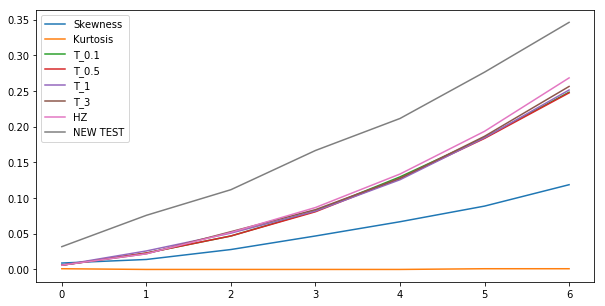

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
time_comp_diff = np.diff(time_comp_total, axis=1)
for i,name in enumerate(['Skewness', 'Kurtosis', 'T_0.1',  'T_0.5',  'T_1',  'T_3', 'HZ', 'NEW TEST']):
    plt.plot(time_comp_diff[:,i],label=name)
    plt.legend(loc='upper left')
plt.show()

## 2. Simulation n°2

Second simulation, we're going to build the comparaison table of percentage of significant tests of multivariate (d=3, 5, 10) normality of 2000 Monte Carlo samples at $\alpha = 0.05$ with fixed sample size n = 50

In [20]:
ep_bound = {3:1.066, 5:1.263, 10:1.690}

n = 50
I_0, I_1 = np.identity(d), np.identity(d)*3
B = np.ones((d,d))*0.9 + np.identity(d)*0.1

def experiment2(pprint=True):
    
#     combinaison_p = [0.5, 0.79, 0.9, 0.5, 0.9]
#     combinaison_mu = [[mu_0, mu_1], [mu_0, mu_1], [mu_0, mu_1], [mu_0, mu_0], [mu_0, mu_0]]
#     combinaison_cov = [[I_0, I_0],[I_0, I_0],[I_0, I_0],[B, I_0],[B, I_0]]
    
    final_array = []
    
    for d in tqdm_notebook([3,5, 10]):
        
        mu_0, mu_1 = [0]*d, [3]*d
        I_0, I_1 = np.identity(d), np.identity(d)*3
        B = np.ones((d,d))*0.9 + np.identity(d)*0.1
        combinaison_p = [0.5, 0.79, 0.9, 0.5, 0.9]
        combinaison_mu = [[mu_0, mu_1], [mu_0, mu_1], [mu_0, mu_1], [mu_0, mu_0], [mu_0, mu_0]]
        combinaison_cov = [[I_0, I_0],[I_0, I_0],[I_0, I_0],[B, I_0],[B, I_0]]
        
        cv_lower, cv_upper = critical_values[d][n][0],  critical_values[d][n][1]

        for c in range(5):
            
            l_skewness = []
            l_kurtosis = []
            l_bhep_01 = []
            l_bhep_05 = []
            l_bhep_1 = []
            l_bhep_3 = []
            l_hz = []
            l_ep = []

            p, mu, cov = combinaison_p[c], combinaison_mu[c], combinaison_cov[c]
            optimal_beta = get_beta(n,d)
            
            for it in range(2000):
                
                samples = get_samples(p, mu,cov, n, d)   
                
                sk = skewness(samples,n)
                l_skewness.append((sk>cv_upper[0] or sk<cv_lower[0] ))
                
                ku = kurtosis(samples,n)
                l_kurtosis.append((ku>cv_upper[1] or ku<cv_lower[1] ))
                
                bhep_01 = BHEP_statistics(samples,0.1,n,d)
                l_bhep_01.append((bhep_01>cv_upper[2] or bhep_01<cv_lower[2] ))  
                
                bhep_05 = BHEP_statistics(samples,0.5,n,d)
                l_bhep_05.append((bhep_05>cv_upper[3] or bhep_05<cv_lower[3] ))  
                
                bhep_1 = BHEP_statistics(samples,1,n,d)
                l_bhep_1.append((bhep_1>cv_upper[4] or bhep_1<cv_lower[4] ))  
                
                bhep_3 = BHEP_statistics(samples,3,n,d)
                l_bhep_3.append((bhep_3>cv_upper[5] or bhep_3<cv_lower[5] ))  
                
                hz = BHEP_statistics(samples,optimal_beta,n,d)
                l_hz.append((hz>cv_upper[6] or hz<cv_lower[6] ))  
                
                ep = GOF_stat(samples)
                l_ep.append((ep>ep_bound[d]))  
            
            if pprint :
                print('\nN={}, p, mu, cov = {},{},{} :\n'.format(n,p,mu,cov))
                print('Skewness :',np.mean(l_skewness)*100)
                print('Kurtosis :',np.mean(l_kurtosis)*100)    
                print('T_0.1 :',np.mean(l_bhep_01)*100)        
                print('T_0.5 :',np.mean(l_bhep_05)*100)             
                print('T_1 :',np.mean(l_bhep_1)*100)             
                print('T_3 :',np.mean(l_bhep_3)*100)             
                print('HZ :',np.mean(l_hz)*100)      
                print('EP :',np.mean(l_ep)*100)      

            final_array.append([np.mean(l_ep)*100, np.mean(l_skewness)*100, np.mean(l_kurtosis)*100, np.mean(l_bhep_01)*100, np.mean(l_bhep_05)*100, \
                          np.mean(l_bhep_1)*100, np.mean(l_bhep_3)*100, np.mean(l_hz)*100])
    return final_array
            
final_array = experiment2(pprint=False)

In [ ]:
#build_array(np.array(final_array, 'int'), info=[3,5,10])

<h3><center> Percentage of significant tests of multivariate normality of 2000 Monte Carlo samples at  𝛼=0.05</center></h3>


| alternative | n | $\mathcal{E}$ | b_1 | b_2 | $T_{0.1}$ | $T_{0.5}$ | $T_1$ | $T_3$ | HZ | 
| - | - | - | - | - | - | - | - | - | - | 
|  | 
| 0.5$N_d$(0,I) + 0.5$N_d$(3,I) | 3 | 64 | 8 | 19 | 5 | 3 | 37 | 55 | 62 | 
| 0.79$N_d$(0,I) + 0.21$N_d$(3,I) | 3 | 95 | 31 | 8 | 34 | 68 | 89 | 54 | 88 | 
| 0.9$N_d$(0,I) + 0.1$N_d$(3,I) | 3 | 91 | 82 | 37 | 82 | 91 | 82 | 30 | 71 | 
| 0.5$N_d$(0,B) + 0.5$N_d$(3,I) | 3 | 70 | 32 | 56 | 28 | 43 | 54 | 38 | 53 | 
| 0.9$N_d$(0,B) + 0.1$N_d$(3,I) | 3 | 63 | 69 | 77 | 65 | 68 | 48 | 19 | 39 | 
|  | 
| 0.5$N_d$(0,I) + 0.5$N_d$(3,I) | 5 | 27 | 7 | 10 | 6 | 4 | 28 | 13 | 38 | 
| 0.79$N_d$(0,I) + 0.21$N_d$(3,I) | 5 | 83 | 20 | 7 | 27 | 56 | 79 | 14 | 76 | 
| 0.9$N_d$(0,I) + 0.1$N_d$(3,I) | 5 | 93 | 75 | 33 | 79 | 91 | 79 | 13 | 67 | 
| 0.5$N_d$(0,B) + 0.5$N_d$(3,I) | 5 | 98 | 74 | 95 | 66 | 90 | 98 | 68 | 97 | 
| 0.9$N_d$(0,B) + 0.1$N_d$(3,I) | 5 | 88 | 92 | 93 | 90 | 89 | 72 | 20 | 62 | 
|  | 
| 0.5$N_d$(0,I) + 0.5$N_d$(3,I) | 10 | 10 | 5 | 6 | 7 | 3 | 6 | 4 | 6 | 
| 0.79$N_d$(0,I) + 0.21$N_d$(3,I) | 10 | 44 | 7 | 5 | 13 | 22 | 16 | 9 | 15 | 
| 0.9$N_d$(0,I) + 0.1$N_d$(3,I) | 10 | 79 | 41 | 22 | 50 | 58 | 17 | 15 | 16 | 
| 0.5$N_d$(0,B) + 0.5$N_d$(3,I) | 10 | 100 | 99 | 100 | 99 | 99 | 100 | 93 | 100 | 
| 0.9$N_d$(0,B) + 0.1$N_d$(3,I) | 10 | 97 | 98 | 98 | 98 | 95 | 62 | 71 | 58 | 

## 3. Simulation n°3

Third and last simulation, we're going to plot the empirical power of tests of multivariate normality (d=5) against several normal mixture location mixture :
1. $0.9N_5(0,I) + 0.1N_5(2,I)$
2. $0.79N_5(0,I) + 0.21N_5(2,I)$
3. $0.9N_5(0,C) + 0.1N_5(2,I)$

Ie the percentage of significant tests of 2000 Monte Carlo samples at 𝛼=0.05  with differents sample sizes n = 25, 50, 100.

In [22]:
ep_bound = {25:1.241, 50:1.263, 100:1.277}
d=5
I_0, I_1 = np.identity(d), np.identity(d)*3
B = np.ones((d,d))*0.9 + np.identity(d)*0.1

def experiment3(pprint=True):
    
    mu_0, mu_1 = [0]*d, [2]*d
    I_0, I_1 = np.identity(d), np.identity(d)*3
    C = np.ones((d,d))*0.5 + np.identity(d)*0.5
    
    combinaison_p = [0.9, 0.79, 0.5]
    combinaison_mu = [[mu_0, mu_1], [mu_0, mu_1], [mu_0, mu_1]]
    combinaison_cov = [[I_0, I_0],[I_0, I_0],[C, I_0]]
    
    final_array = []
    
    for n in tqdm_notebook([25,50, 100]):
        
        cv_lower, cv_upper = critical_values[d][n][0],  critical_values[d][n][1]
        
        for c in range(3):
            
            l_skewness = []
            l_kurtosis = []
            l_hz = []
            l_ep = []

            p, mu, cov = combinaison_p[c], combinaison_mu[c], combinaison_cov[c]
            optimal_beta = get_beta(n,d)
            
            for it in range(2000):

                samples = get_samples(p, mu,cov, n, d)   
                
                sk = skewness(samples,n)
                l_skewness.append((sk>cv_upper[0] or sk<cv_lower[0] ))
                
                ku = kurtosis(samples,n)
                l_kurtosis.append((ku>cv_upper[1] or ku<cv_lower[1] ))
                
                hz = BHEP_statistics(samples,optimal_beta,n,d)
                l_hz.append((hz>cv_upper[6] or hz<cv_lower[6] ))  
                
                ep = GOF_stat(samples)
                l_ep.append((ep>ep_bound[n]))  
                
            if pprint  :
                print('\nN={}, p, mu, cov = {},{},{} :\n'.format(n,p,mu,cov))
                print('Skewness :',np.mean(l_skewness)*100)
                print('Kurtosis :',np.mean(l_kurtosis)*100)           
                print('HZ :',np.mean(l_hz)*100)      
                print('EP :',np.mean(l_ep)*100)      

            final_array.append([np.mean(l_ep)*100, np.mean(l_skewness)*100, np.mean(l_kurtosis)*100, np.mean(l_hz)*100])
    return final_array
            
final_array = experiment3(pprint=False)
final_array = np.array(final_array)

Simulation n°3 : 



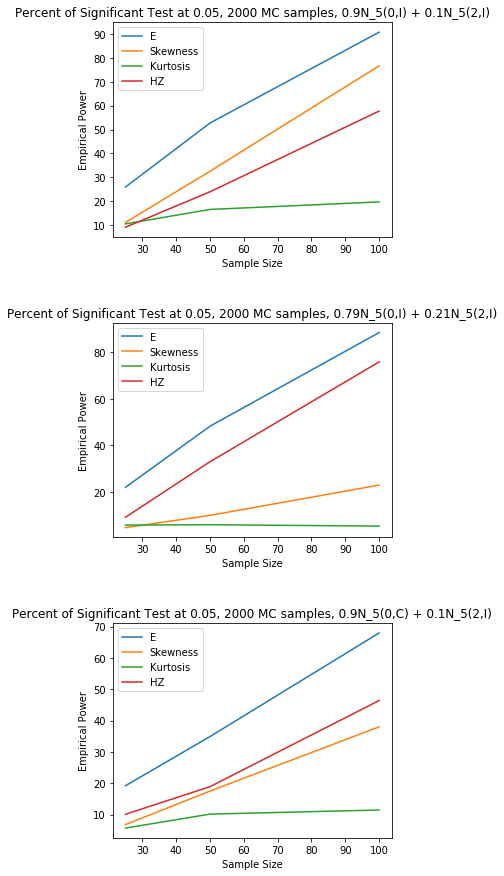

In [23]:
title = 'Percent of Significant Test at 0.05, 2000 MC samples, '
title_ex = ['0.9N_5(0,I) + 0.1N_5(2,I)', '0.79N_5(0,I) + 0.21N_5(2,I)', '0.9N_5(0,C) + 0.1N_5(2,I)']
plt.figure(figsize=(5,15))
print('Simulation n°3 : \n')
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.ylabel('Empirical Power')
    plt.xlabel('Sample Size')
    plt.title(title+title_ex[i])
    for j,name in enumerate(['E', 'Skewness', 'Kurtosis','HZ']):
        plt.plot([25,50,100],final_array[[i+3*k for k in range(3)],j], label = name)
        plt.legend(loc='upper left')
plt.subplots_adjust(hspace =0.4)
plt.show()